
# Wind Tunnel Lab Report

Peter Sharpe

MIT 16.110: Flight Vehicle Aerodynamics

## Abstract

### TODO do this

## Document Notes
This lab report is a fully-interactive Jupyter Notebook available at https://tinyurl.com/16110LabSharpe. Assuming you have a standard scientific Python >=3.7 distribution (such as Anaconda) installed, you can freely interact with this entire document as you please.

Alternatively, the following Binder link will allow you to interact with this document in your browser: 

### TODO add binder link

We begin our analysis with the following standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import torch # PyTorch, a numerics package (primarily used for machine learning, 
             # but we're using it here as an automatic differentiation framework 
             # for uncertainty propagation)
import pint

We also set up these libraries:

In [3]:
style.use('seaborn') # Use the seaborn plotting style
u = pint.UnitRegistry() # Use the unit conversions from the Pint package

## Experiment Setup

### TODO do this

In this lab, we seek to determine the drag on a NACA 0050 body of revolution of length $l = 10 $ in. We approach this problem with three methods:

1. Direct force measurement
2. Wake survey measurement
3. Computational modeling

The first two methods described here are experimental in nature. The experimental apparatus consists of a 1:1 scale model of the body of revolution placed in Building 31's 1.5 x 1.5 ft. open-jet tunnel. 

The body of revolution is held in place with a small, streamlined strut. This strut consists of a straight extruded NACA 0010 airfoil with a chord $c = 1.25$ in. The strut meets the body of revolution in such a way that their trailing edges are coincident. Furthermore, the body of revolution is held exactly in the center of the 1.5 x 1.5 ft. tunnel, which implies that approximately 9" of the extruded strut sees the jet's airflow (assuming the free jet stays collimated). Thus, the exposed planform area of the strut is:

$$S_{strut} = 9" \cdot 1.25" = 11.25 in^2$$ 

## Data Imports
This section details the process of importing the raw data from our experiment. This can be freely skipped, but it has been included here to support scientific reproducibility.

All data in this section is available at: https://tinyurl.com/16110LabSharpeData. The /data/ subdirectory should be placed in the same directory as this Jupyter notebook.

### Direct Force Measurement Section Data Imports
First, we write a function that will parse the `*.csv` files taken during the direct force measurement section of our experiment.

In [4]:
def parse_wind_tunnel_csv(filename):
    """
    Parses the CSV files written during the experiment.
    :param filename: Name of the file to be read.
    :return: Data, in the format as follows:
    ### All of the wind tunnel data files are Nx2 arrays in the format [load_cell_voltage, measured_dynamic_pressure_in_torr].
    ### Each row represents a separate data collect (0.001 sec spacing).
    ### Note that the load cell voltage should be converted to load via a linear fit to tare data.
    ### Note that the dynamic pressure measurements should be calibrated against the tare values.
    """
    raw_data = np.genfromtxt(
        filename,
        skip_header=7,
        delimiter=',',
        usecols=(2, 3),
        dtype='str'
    )
    data = np.zeros(raw_data.shape)
    for i in range(raw_data.shape[0]):
        for j in range(raw_data.shape[1]):
            data[i, j] = float(raw_data[i, j].split("\"")[1])

    return data

We then proceed to read the wind tunnel data as follows:

In [5]:
# Load cell tares before experiments
wt_load_cell_tare_no_weight_before_experiments = parse_wind_tunnel_csv(
    'data/load_cell_tare_no_weight_before_all_experiments/Analog - 10-24-2019 10-29-09.787 AM.csv')
wt_load_cell_tare_8oz_weight_before_experiments = parse_wind_tunnel_csv(
    'data/load_cell_tare_8oz_weight_before_all_experiments/Analog - 10-24-2019 10-31-00.065 AM.csv')

# Dynamic pressure tare before experiment (this is redundant from prior data, probably won't use this)
wt_q_tare_before_experiments = parse_wind_tunnel_csv(
    'data/load_cell_and_q_tare_no_weight_no_speed_before_all_experiments/Analog - 10-24-2019 10-36-31.486 AM.csv')

# Airfoil at-speed data
wt_raw_data_30_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_30_mph/Analog - 10-24-2019 10-40-07.697 AM.csv')
wt_raw_data_35_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_35_mph/Analog - 10-24-2019 10-43-23.611 AM.csv')
wt_raw_data_40_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_40_mph/Analog - 10-24-2019 10-45-19.445 AM.csv')
wt_raw_data_50_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_50_mph/Analog - 10-24-2019 10-47-22.874 AM.csv')
wt_raw_data_60_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_60_mph/Analog - 10-24-2019 10-49-37.397 AM.csv')
wt_raw_data_70_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_70_mph/Analog - 10-24-2019 10-54-41.000 AM.csv')
wt_raw_data_73_mph = parse_wind_tunnel_csv(
    'data/transition_measurement_approx_73_mph/Analog - 10-24-2019 11-00-01.410 AM.csv')

# Tares after experiments
wt_load_cell_tare_no_weight_after_experiments = parse_wind_tunnel_csv(
    'data/load_cell_tare_no_weight_after_transition_measurement/Analog - 10-24-2019 11-04-20.174 AM.csv')
wt_load_cell_tare_2oz_weight_after_experiments = parse_wind_tunnel_csv(
    'data/load_cell_tare_2oz_weight_after_transition_measurement/Analog - 10-24-2019 11-06-06.230 AM.csv')
wt_load_cell_tare_8oz_weight_after_experiments = parse_wind_tunnel_csv(
    'data/load_cell_tare_8oz_weight_after_transition_measurement/Analog - 10-24-2019 11-05-31.538 AM.csv')

### Rake Section Data Imports

Next, we write a function that will read our manometer data taken during the rake section of our experiment:

In [6]:
def parse_manometer_csv(filename):
    """
    Reads the manometer data from the CSV files taken during the experiment.
    :param filename: Name of the CSV file to be read
    :return: a tuple of data, as follows:
    ### Manometer Data Format
    ### All of the manometer data files are vectors of length 25 corresponding to the manometer measurement at that pressure probe.
    """
    raw_data = np.genfromtxt(
        filename,
        delimiter=',',
        skip_header=1
    )

    manometer_40_mph_angle_1 = raw_data[:, 2]
    manometer_40_mph_angle_2 = raw_data[:, 3]
    manometer_60_mph_angle_1 = raw_data[:, 7]
    manometer_60_mph_angle_2 = raw_data[:, 8]

    return manometer_40_mph_angle_1, manometer_40_mph_angle_2, manometer_60_mph_angle_1, manometer_60_mph_angle_2


Using the aformentioned function, we read the manometer data:

In [7]:
manometer_40_mph_angle_1, manometer_40_mph_angle_2, manometer_60_mph_angle_1, manometer_60_mph_angle_2 = parse_manometer_csv(
    'data/manometer_readings.csv'
)

We can verify that the manometer data is sensible by visualizing the manometer measurements for the 40 mph, angle 1 case. (Here, angle 1 and angle 2 are taken to refer to manometer measurements with the rake in the $+45°$ and $-45°$ positions, respectively.)

Text(0, 0.5, 'Manometer Reading [inches]')

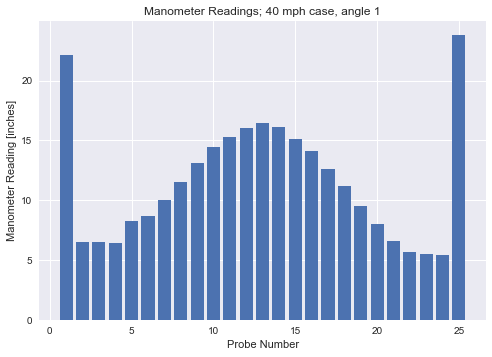

In [11]:
plt.bar(np.arange(len(manometer_40_mph_angle_1))+1,manometer_40_mph_angle_1)
plt.title("Manometer Readings; 40 mph case, angle 1")
plt.xlabel("Probe Number")
plt.ylabel("Manometer Reading [inches]")

This data appears to be qualitatively correct. The right-most probe is measuring the 


## Preliminary Data Processing
In this section, we begin to clean up and process the data.

First, we write a function to get the standard deviation of the mean of a dataset. Mathematically, this is expressed as the following relation:

$$ \sigma_{\bar X} = \frac{1}{\sqrt{n}} \sigma_X $$

where:

$ X$ is the dataset,
$ \sigma_{\bar X}$ is the standard deviation of the dataset's mean,
$ n$ is the number of samples in the dataset, and
$ \sigma_X$ is the standard deviation of the dataset itself.